In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import pymc3 as pm

from scipy.interpolate import griddata

plt.style.use('ggplot')
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Why normal distributions are normal

Suppose you and a thousand of your closest friends line up on the halfway line of a soccer
field (football pitch). Each of you has a coin in your hand. At the sound of the whistle, you
begin flipping the coins. Each time a coin comes up heads, that person moves one step
towards the left-hand goal. Each time a coin comes up tails, that person moves one step
towards the right-hand goal. Each person flips the coin 16 times, follows the implied moves,
and then stands still. Now we measure the distance of each person from the halfway line.
Can you predict what proportion of the thousand people who are standing on the halfway
line? How about the proportion 5 yards left of the line

It's hard to say where any individual person will end up, but you can say with great confidence what the collection of positions will be. The distances will be distributed in approximately normal, or Gaussian, fashion. This is true even thought the underlying distribution is binomial. 

### Normal by addition

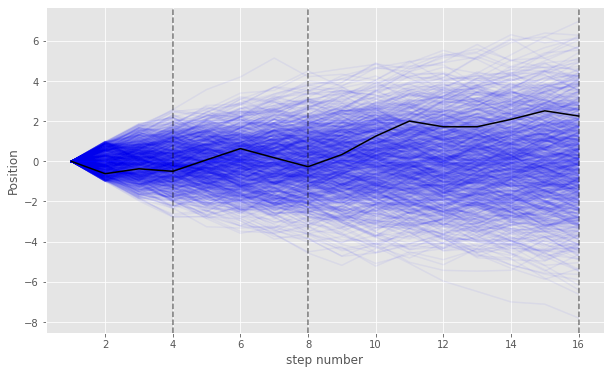

In [2]:
np.random.seed(1234)
steps = 16
repetitions = 1000
x = np.zeros([steps, repetitions])
for i in range(x.shape[1]):
    x[1:, i] = np.cumsum(np.random.uniform(-1, 1, steps - 1))
plt.figure(figsize=(10, 6))
plt.plot(range(1, steps+1), x[:, :], c='b', alpha=0.05)
plt.plot(range(1, steps+1), x[:, 0], c='k')
plt.axvline(4, linestyle='--', c='k', alpha=0.5)
plt.axvline(8, linestyle='--', c='k', alpha=0.5)
plt.axvline(16, linestyle='--', c='k', alpha=0.5)
plt.xlabel('step number')
plt.ylabel('Position')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharex=True)
sns.kdeplot(x[3, :], ax=ax[0], bw_adjust=0.2)
sns.kdeplot(x[7, :], ax=ax[1], bw_adjust=0.2)
sns.kdeplot(x[15, :], ax=ax[2], bw_adjust=0.2)

ax[0].set_title('4 steps')
ax[1].set_title('8 steps')
ax[2].set_title('16 steps')

for i in range(3):
    ax[i].set_ylabel('Density')
    ax[i].set_xlabel('Position')
    ax[i].set_xlim(-6, 6)
    ax[i].set_xticks([-6, -3, 0, 3, 6])

Any process that adds together random values from the same distribution converges to a normal. But it's not easy to grasph why addition should result in a bell curve of sums.

The conceptual way to think of the process: whether the average value of the source distribution, each sample from it can be thought of as a fluctuation from the average value. When we begin to add these fluctuations together, they also begin to cancel one another out.

Depending on the underlying distribution, the convergence might be slow, but it will be inevitable.

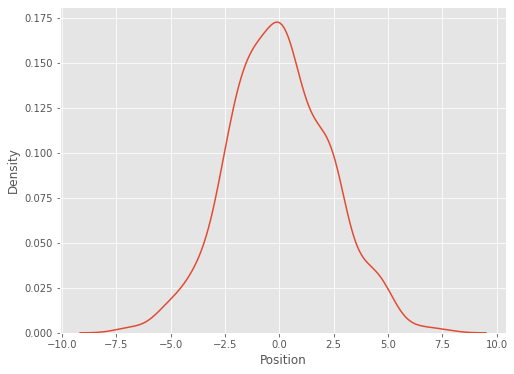

In [4]:
pos = np.random.uniform(-1, 1, size=(16, 1000)).sum(0)
_, ax = plt.subplots(figsize=(8, 6))
sns.kdeplot(pos, ax=ax)
ax.set_xlabel('Position')
ax.set_ylabel('Density');

### Normal by multiplication

Suppose the growth rate of an organism is influenced by a dozen loci, each with several alleles that code for more growth. Suppose also that all of these loci interact with each other, such that each increase growth by a percentage. This means that their effects multiply, rather than add.

In [5]:
np.product(1 + np.random.uniform(0, 0.1, 12))

1.597677949223938

Above code samples 12 random numbers between 0 and 0.1, each representing a proportional increase in growth. What distribution do you think these random products will take? Normal distribution.

Multiplying small numbers is approximately the same as addition. Small effects that multiply together are approximately additive, and so they tend to stabilize on Gaussian distribution. 

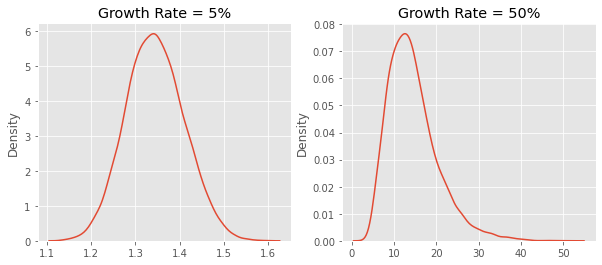

In [6]:
pos05 = np.random.uniform(1, 1.05, size=(12, 10000)).prod(0)
pos50 = np.random.uniform(1, 1.5, size=(12, 10000)).prod(0)
_, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.kdeplot(pos05, ax=ax[0])
sns.kdeplot(pos50, ax=ax[1])
ax[0].set_title('Growth Rate = 5%')
ax[1].set_title('Growth Rate = 50%');

### Normal by log-multiplication

Large deviates that are multiplied together do not produce Gaussian distributions, but they do tend to produce Gaussian distributions on the log scale.

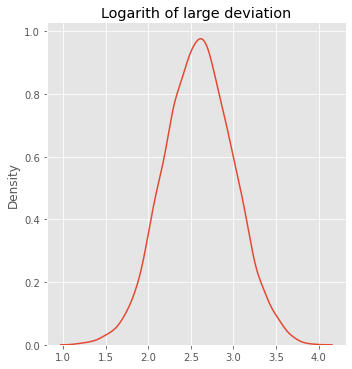

In [7]:
log_big = np.log(np.random.uniform(1, 1.5, size=(12, 10000)).prod(0))
sns.displot(log_big, kind='kde')
plt.title('Logarith of large deviation');

### Using Gaussian distributions

Gaussian distribution as a skeleton for our hypotheses, building up models of measurements as aggregations of normal distributions. The justification for using Gaussian distribution fall into two broad categories (1) ontological, and (2) epistemological.

**Ontological justification**: The world is full of Gaussian distributions, approximately because the processes add together fluctuations. Add repeatedly adding finite fluctuations results in a distribution of sums that have shed all information about the underlying process, aside from mean and spread. 

**Epistemological justification**: Gaussian distribution is the most natural expression of our state of ignorance, because if all we are willing to assume is that a measure has finite variance, the Gaussian distribution is the shape that can be realized in the large number of ways and does not introduce any new assumptions. 

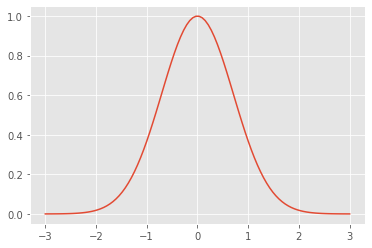

In [8]:
x = np.linspace(-3, 3, 100)
plt.plot(x, np.exp(-x**2));

The probability densities can be greater than 1. Probability density is the rate of change in cummulative probability. So where cummulative probability is increasing rapidly, density can easily exceed 1. If we calculate the area under the density function, it will never exceed 1. 

In [9]:
stats.norm.pdf(0, 0, .1)

3.989422804014327

## Gaussian Model of Height

The data Howell1 are partial census data for the Dobe area !Kung San, compiled from interviews conducted by Nancy Howell in the late 1960s. The !Kung San is the most famous foraging population of the 20th century, largely because of detailed quantitative studies by people like Howell.

In [10]:
import pandas as pd
d = pd.read_csv('/home/telescreen/Workspace/fun/pymc-devs-resources/Rethinking_2/Data/Howell1.csv', sep=';', header=0)
d.describe()

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
25%,125.095000,22.007717,12.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
75%,157.480000,47.209005,43.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


In [11]:
d[d.age > 18]

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
534,162.560,47.031821,27.0,0
537,142.875,34.246196,31.0,0
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0


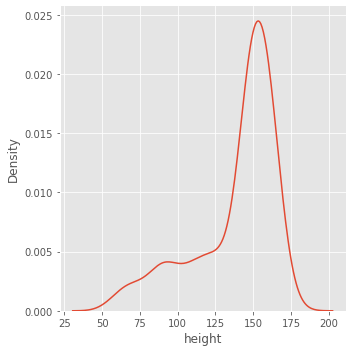

In [12]:
sns.displot(d.height, kind='kde');

**The model**: The height data looks Gaussian. This may be because height is a sum of many small growth factors. It's reasonable for the moment to adopt the stance that the model should use a Gaussian distribution for the probability distribution of the data. 

To define the heights as normally distributed with a mean $\mu$ and standard deviation $\sigma$, we write:

$$ h_i \sim \text{Normal}(\mu, \sigma) $$

The short model above is somethings described as assuming that the values $h_i$ are independent and identically distributed, which may be abbreviated as iid. A moment's reflection tells us that this is hardly true, in a physical sense. It is hard to argue that every measurement is independent of the others. The assumption does not have to seem awkward as long as you remember that probability is inside the golem, not outside in the world. It is an *epistemological* assumption. The point to say is that in ignorance of such correlations the most conservative distribution to use i.i.d.

To complete the model, we're going to need some priors. The parameters to be estimated are both $\mu$ and $\sigma$, so we need a prior $Pr(\mu, \sigma)$, the joint prior probability for all parameters. In most cases, priors are specfified independently for each parameter, which amounts to assuming $Pr(\mu, \sigma) = Pr(\mu)Pr(\sigma)$. 

$$ h_i \sim Normal(\mu, \sigma) $$
$$ \mu \sim Normal (178, 20) $$
$$ \sigma \sim Uniform(0, 50) $$

Why 178cm? it is chosen based on domai-specfic information. It's good idea to plot your priors so you have a sense of the assumption they build into the model. 

It will help to see what these priors imply about the distribution of individual heights. This is an essential part of your modeling, the **PRIOR PREDICTIVE** simulation. By simulating from this distribution, you can see what your choices imply about observable height. Prior predictive simulation is very useful for assigning sensible priors, because it can be quite hard to anticipate how priors influence the observable variables. 

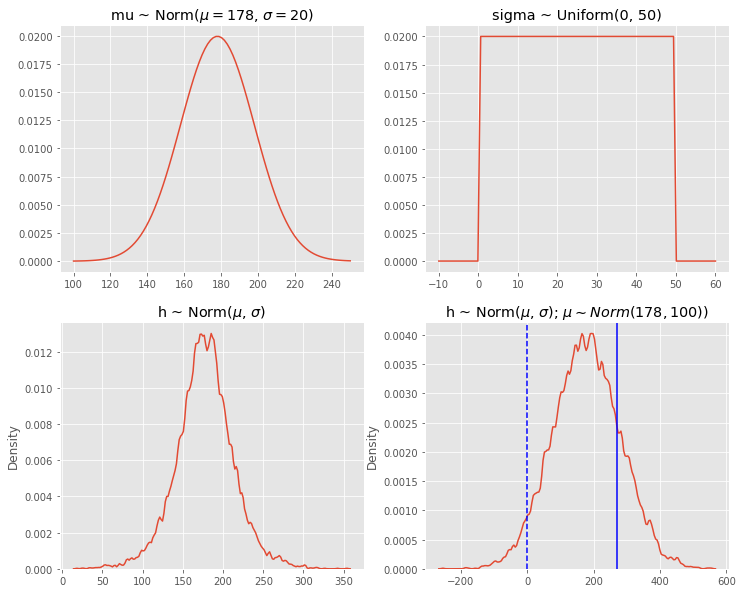

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(12,10))

mu_range = np.linspace(100, 250, 100)
ax[0,0].plot(mu_range, stats.norm.pdf(mu_range, loc=178, scale=20))
ax[0,0].set_title('mu ~ Norm($\mu=178$, $\sigma=20$)')
sigma_range = np.linspace(-10, 60, 100)
ax[0,1].plot(sigma_range, stats.uniform.pdf(sigma_range, 0, 50))
ax[0,1].set_title('sigma ~ Uniform(0, 50)')

sample_size = 10000
sample_mu = stats.norm.rvs(loc=178, scale=20, size=sample_size)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=sample_size)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma, size=sample_size)
sns.kdeplot(prior_h,ax=ax[1,0], bw_adjust=0.25)
ax[1, 0].set_title('h ~ Norm($\mu$, $\sigma$)');

sample_mu2 = stats.norm.rvs(loc=178, scale=100, size=sample_size)
prior_h2 = stats.norm.rvs(loc=sample_mu2, scale=sample_sigma, size=sample_size)
sns.kdeplot(prior_h2, ax=ax[1,1], bw_adjust=0.25)
ax[1, 1].set_title('h ~ Norm($\mu$, $\sigma$); $\mu \sim Norm(178, 100)$)')
ax[1, 1].axvline(x = 0, linestyle='--', color='b')
ax[1, 1].axvline(x = 272, linestyle='-', color='b');

in case we choose prior probability as flat as $\mu \sim Norm(178, 100)$, we expect that 4% of people to have negative height. It also expects some giants. One of the tallest people in recorded history, Robert Pershing Wadlow (1918 - 1940) stood 272cm tall. In our prior predictive simulation, 18% of people (right of the solid right) are taller than this).

In [14]:
len(prior_h2[prior_h2 <= 0]) / sample_size

0.0408

In [15]:
len(prior_h2[prior_h2 >= 272]) / sample_size

0.182

**Grid approximation of the posterior distribution**: It's worth quickly mapping out the posterior distribution through brute force calculations. This isn't the approach I encourage in any other place, because it is laborious and computationally expensive. 

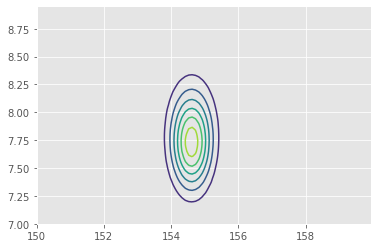

In [16]:
# We calculate the probability for all people with age greater than 18.
d2 = d[d.age >= 18]

post = np.mgrid[150:160:0.05, 7:9:0.05].reshape(2, -1).T
likehood = [
    np.sum(stats.norm.logpdf(d2.height, loc=post[i, 0], scale=post[i, 1])) 
    for i in range(len(post))
]
post_prod = (
    likehood
    + stats.norm.logpdf(post[:, 0], loc=178, scale=20)             
    + stats.uniform.logpdf(post[:, 1], loc=0, scale=50)
)
post_prob = np.exp(post_prod - np.max(post_prod))

xi = np.linspace(post[:, 0].min(), post[:, 0].max(), 100)
yi = np.linspace(post[:, 1].min(), post[:, 1].max(), 100)
zi = griddata((post[:, 0], post[:, 1]), post_prob, (xi[None, :], yi[:, None]))

plt.contour(xi, yi, zi);

**Sampling from the posterior** To study this posterior distribution in more detail, again I'll push the flexible approach of sampling parameter values from it. The only new trick is that since there are two parameters, and we want to sample combinations of them, we first randomly sample row numbers in post in proportion to the values in post_prob. Then we pull out the parameter values on those randomly sampled rows.

There are two dimensions and so there is a geometric increase in bother.

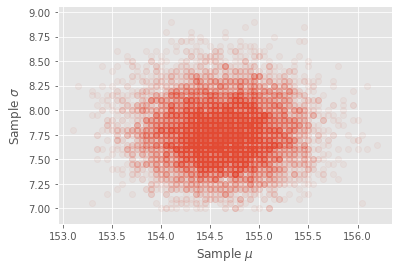

In [17]:
sample_rows = np.random.choice(np.arange(len(post)), size=10000, \
                              replace=True, p=post_prob/np.sum(post_prob))
sample_mu = post[:, 0][sample_rows]
sample_sigma = post[:, 1][sample_rows]

plt.plot(sample_mu, sample_sigma, 'o', alpha=0.05)
plt.axis('Equal')
plt.xlabel('Sample $\mu$')
plt.ylabel('Sample $\sigma$');

Now that you have these samples, you can describe the distribution of confidence in each combination of $\mu$ and $\sigma$ by summarizing the samples. To characterize the sahpes of the *marginal* posterior densities of $\mu$ and $\sigma$, we need to do

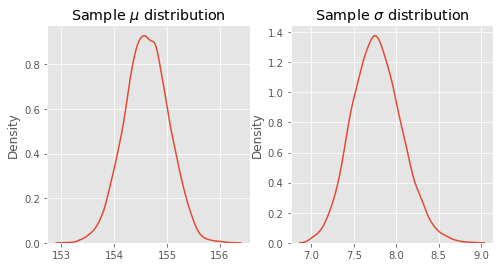

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(sample_mu, ax=ax[0])
ax[0].set_title("Sample $\mu$ distribution")
sns.kdeplot(sample_sigma, ax=ax[1])
ax[1].set_title("Sample $\sigma$ distribution");

In [19]:
print(az.hdi(sample_mu))
print(az.hdi(sample_sigma))

[153.85 155.35]
[7.3  8.35]


**Finding the posterior distribution with Quadratic approximation**

In [20]:
basic_model = pm.Model()
with basic_model:
    # Priors for unknown model parameters
    mu = pm.Normal("mu", mu=178, sd=20)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    
    # Likelihood of observations.
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)

map_estimate = pm.find_MAP(model=basic_model)
map_estimate

{'mu': array(154.60702358),
 'sigma_interval__': array(-1.69876478),
 'sigma': array(7.73133303)}

In [21]:
with basic_model:
    trace = pm.sample(1000, tune=1000)
    print(az.summary(trace, round_to=2, kind="stats"))

<ipython-input-21-3e5e21900b88>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


         mean    sd  hdi_3%  hdi_97%
mu     154.60  0.41  153.86   155.37
sigma    7.78  0.30    7.24     8.33


## Linear Prediction

Typically we are interested in modeling how an outcome is related to some other variable, a **PREDICTOR VARIABLE**. If the predictor variable has any statistical association with the outcome variable, then we can use it to predict the outcome. Let's look at how height in these Kalahari foragers covaries with weight.

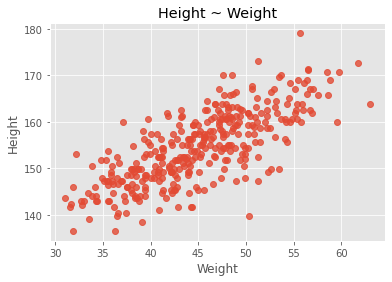

In [22]:
plt.plot(d2.weight, d2.height, 'o', alpha=0.8)
plt.title("Height ~ Weight")
plt.xlabel('Weight')
plt.ylabel('Height');

> **Rethinking: What is “regression”**? Many diverse types of models are called “regression.” The term
has come to mean using one or more predictor variables to model the distribution of one or more
outcome variables. The original use of term, however, arose from anthropologist Francis Galton’s
(1822–1911) observation that the sons of tall and short men tended to be more similar to the popula-
tion mean, hence *regression to the mean.* 

> The causal reasons for regression to the mean are diverse. In the case of height, the causal expla-
nation is a key piece of the foundation of population genetics. But this phenomenon arises statistically
whenever individual measurements are assigned a common distribution, leading to shrinkage as each
measurement informs the others. In the context of Galton’s height data, attempting to predict each
son’s height on the basis of only his father’s height is folly. Better to use the population of fathers.
This leads to a prediction for each son which is similar to each father but “shrunk” towards the over-
all mean. Such predictions are routinely better. This same regression/shrinkage phenomenon applies
at higher levels of abstraction and forms one basis of multilevel modeling (Chapter 13).

**The linear model strategy**
The strategy is to make the parameter for the mean of a Gaussian distribution $\mu$ into a linear function of the predictor variable. The linear model strategy instructs the golem to assume that the predictor variable has a constant and additive relationship to the mean of the outcome. 

$$ h_i \sim Normal(\mu, \sigma) $$
$$ \mu_i = \alpha + \beta(x_i - \bar{x}) $$
$$ \alpha \sim Normal(178, 20) $$
$$ \beta \sim Normal(0, 10) $$
$$ \sigma \sim Uniform(0, 50) $$

The line $\mu_i = \alpha + \beta(x_i - \bar{x})$  telss the regression golem that you are asking two questions about the mean of the outcome:

(1) What is the expected height when $x_i = \bar{x}$
(2) what is the change in expected height, when $x_i$ chagnes by 1 unit?

*Priors* The remaining lines in the model define distributions for the unobserved variables. Why have $\beta$ follows Gaussian with mean = 0. Because we want the algorithm to rule out the relationship of weight and height.

We know that average height increases with average weight. We can restrict height to positive values. The easiest way to do this is to define the prior as Log-Normal.

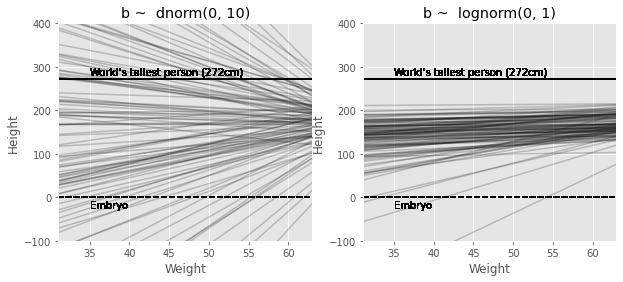

In [23]:
np.random.seed(2971)
N = 100
a = stats.norm.rvs(loc=178, scale=20, size=N)
b = stats.norm.rvs(loc=0, scale=10, size=N)

x = np.linspace(0, d2.weight.max(), 100)
xbar = d2.weight.mean()

_, ax = plt.subplots(1, 2, figsize=(10, 4))

for i in range(N):
    ax[0].plot(a[i] + b[i] * (x - xbar), 'k', alpha=0.2)
    ax[0].set_title('b ~  dnorm(0, 10)')
    ax[0].set_xlim(d2.weight.min(), d2.weight.max())
    ax[0].set_ylim(-100, 400)
    ax[0].axhline(0, c='k', ls='--')
    ax[0].axhline(272, c='k')
    ax[0].set_xlabel('Weight')
    ax[0].set_ylabel('Height')
    ax[0].text(x=35, y=282, s="World's tallest person (272cm)")
    ax[0].text(x=35, y=-25, s="Embryo")
    
b = stats.lognorm.rvs(s=1, scale=1, size=N)
for i in range(N):
    ax[1].plot(a[i] + b[i] * (x - xbar), 'k', alpha=0.2)
    ax[1].set_title('b ~  lognorm(0, 1)')
    ax[1].set_xlim(d2.weight.min(), d2.weight.max())
    ax[1].set_ylim(-100, 400)
    ax[1].axhline(0, c='k', ls='--')
    ax[1].axhline(272, c='k')
    ax[1].set_xlabel('Weight')
    ax[1].set_ylabel('Height')
    ax[1].text(x=35, y=282, s="World's tallest person (272cm)")
    ax[1].text(x=35, y=-25, s="Embryo")

**Rethinking: What's the correct prior?** People commonly ask what the correct prior is for a given analysis. THe question sometimes implies that for any given set of data, there is a uniquely correct prior that must be used, or else the analysis will be invalid. This is a mistake. There is no more a uniquely correct prior that there is a uniquely correct likelihood. Statistical models are machines for inference. Many machines will work, but some work better than others. Priors can be wrong, but only in the same sense that a kind of hammer can be wrong for building a table.

In choosing priors, there are simple guidelines to get you started. Priors encode states of information before seeing data. So priors allow us to explore the consequences of beginning with different information. In case in which we have good prior information that discounts the plausibility of some parameter values, like negative associations between height and weight, we can encode that information directly into priors. When we don't have such information, we still usually know enough about the plausible range of values. And you can vary the priors and repeat the analysis in order to study how different states of initial information influence inference. Frequently, there are many reasonable choices for a prior, and all of them produce the same inference. And conventional Bayesian priors are *conservative*, relative to conventional non-Bayesian approaches.

Making choices tends to make novices nervous. There's illusion sometimes that default proceduces are more objective than procedures that require user choice, such as choosing priors. If that's true, then all "objective" means is that everyone does the same thing. It carries no guarantess of realism or accuracy. 

**Finding the posterior distribution**


$$ h_i \sim Normal(\mu, \sigma) $$
$$ \mu_i = \alpha + \beta(x_i - \bar{x}) $$
$$ \alpha \sim Normal(178, 20) $$
$$ \beta \sim LogNormal(0, 1) $$
$$ \sigma \sim Uniform(0, 50) $$

In [24]:
d2 = d[d.age >= 18]
xbar = d2.weight.mean()
with pm.Model() as model:
    # Priors for unknown model parameters
    a = pm.Normal("a", mu=178, sd=20)
    b = pm.Lognormal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = a + b*(d2.weight - xbar)
    
    # Likelihood of observations.
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    trace = pm.sample(1000, tune=1000)

<ipython-input-24-e468a6828d69>:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


**Rethinking: Everything that depends upon parameters has a posterior distribution**. In the model above, the parameter $\mu$ is no longer a parameter, since it has become a function of the parameters $\alpha$ and $\beta$. But since the parameters $\alpha$ and $\beta$ have a joint posterior, so too does $\mu$. Since parameters are uncertain, everything that depends upon them is also uncertain. This include statistics like $\mu$, as well as model-based predictions, measures of fit, and everything else that uses parameters. By working with samples from posterior, all you have to do to account for posterior uncertainty in any quantity is to compute that quantity for each sample from the posterior. The resulting quantities, one for each posterior sample, will approximate the quantity's posterior distribution. 

**Interpreting the posterior distribution**. Model can only report posterior distribution. It's your responsibility to process the answer and make sense of it. There are two broad categories of processing (1) Reading tables and (2) Plotting simulations. 

Plotting the implications of your models will allow you to inquire about things that are hard to read from tables:

1. Whether or not the model fitting procedure worked correctly.
2. The *absolute* magnitude, rather than merely *relative* magnitude, of a relationship between outcome and predictor.
3. The uncertainty surrounding an average relationship
4. The uncertainty surrounding the implied predictions of the model, as these are distinct from mere parameter uncertainty. 

**Rethinking: What do parameters mean?** Bayesian perspective: *Posterior probabilities of parameter values describe the relative compatibility of different states of the world with the data, according to the model*. These are small world numbers. So reasonable people may disagree about the large world meaning, and the details of those disagreements depend strongly upon context.

**(Personal)**: A model should be used to facilitate productive disagreements, because they lead to model criticism and revision. A model produces a view of the world with data, not the general truth about the world. We reason about the world based on the view provided by the model.

In [25]:
az.summary(trace, kind='stats', round_to=2)

/home/telescreen/Softwares/miniconda3/envs/kaggle/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
a,154.60,0.27,154.13,155.14
b,0.90,0.04,0.82,0.98
sigma,5.11,0.19,4.73,5.48


The value of $\beta$ suggests that a person 1kg heavier is expected to be 0.90 cm taller. 94% of the posterior probability lies between 0.82 and 0.99. That suggests that $\beta$ values clost to zero or greatly above one are highly incompatible with thest data and this model. The model is saying that if you are committed to a line relationship between height and weight, then lines with a slope around 0.9 are plausible ones.

In [26]:
trace_df = pm.trace_to_dataframe(trace)
trace_df.cov().round(3)

,a,b,sigma
a,0.074,-0.000,0.000
b,-0.000,0.002,0.000
sigma,0.000,0.000,0.038


**Plotting posterior inference against the data**

It's useful to plot the posterior inference against the data. Not only does plotting help in interpreting the posterior, but it also provides an informal check on model assumptions. Even if you only treat plots as a way to help in interpreting the posterior, they are invaluable. 

(1) *Raw data and single prediction line*

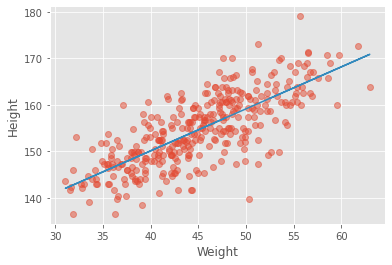

In [27]:
plt.plot(d2.weight, d2.height, 'o', alpha=0.5)
plt.ylabel('Height')
plt.xlabel('Weight')
plt.plot(d2.weight, trace_df['a'].mean() + trace_df['b'].mean()*(d2.weight-xbar));

(2) *Adding uncertainty around the mean*. Plots of the average line are useful for getting an impression of the magnitude of the estimated influence of a variable. But they do a poor job of communicating uncertainty. We could plot a bunch of lines to see how uncertainty looks like.

In the below graph, the cloud of regression lines grows more compact as the sample size increases. This is a result of the model growing more confident about the location of the mean.

<ipython-input-28-fe9f960cfbbb>:18: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=1000)


<ipython-input-28-fe9f960cfbbb>:18: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=1000)


<ipython-input-28-fe9f960cfbbb>:18: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=1000)


<ipython-input-28-fe9f960cfbbb>:18: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=1000)


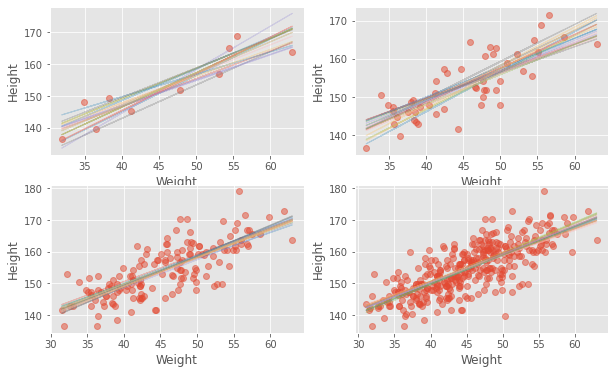

In [28]:
import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

N = [10, 50, 150, 352]
dN = [d2[:Size] for Size in N]
all_traces = []
for s in dN:
    xbar = s.weight.mean()
    with pm.Model() as mN:
        # Priors for unknown model parameters
        a = pm.Normal("a", mu=178, sd=20)
        b = pm.Lognormal("b", mu=0, sd=1)
        sigma = pm.Uniform("sigma", lower=0, upper=50)
        mu = pm.Deterministic("mu", a + b*(s.weight - xbar))
        # Likelihood of observations.
        height = pm.Normal("height", mu=mu, sd=sigma, observed=s.height)
        trace = pm.sample(1000, tune=1000)
        all_traces.append(pm.trace_to_dataframe(trace))
        
fig = plt.figure(figsize=(10,6))
for i in range(len(dN)):
    xbar = dN[i].weight.mean()
    ax = fig.add_subplot(2, 2, i+1)
    ax.plot(dN[i].weight, dN[i].height, 'o', alpha=0.5)
    ax.set_ylabel('Height')
    ax.set_xlabel('Weight')
    for j in range(20):
        ax.plot(dN[i].weight, all_traces[i]['a'][j] + \
                all_traces[i]['b'][j]*(dN[i].weight-xbar), linewidth=1, alpha=0.3);

*Plotting regression intervals and contours*: It's more common and often much clearer to see the uncertainty displayed by plotting an interval or contour around the average regression line. 

Focus for the moment on a single *weight* value, say 50kg. You can quickly make a list of 10,000 values of $\mu$ for an individual who weighs 50kg, by using your samples from the posterior.

<ipython-input-29-9ff3d978e133>:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=1000)


High Density Interval: [158.62077759 159.71061268]


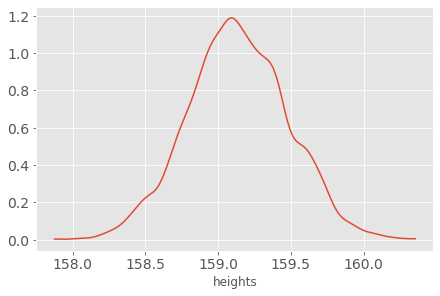

In [29]:
d2 = d[d.age >= 18]
xbar = d2.weight.mean()
with pm.Model() as model:
    # Priors for unknown model parameters
    a = pm.Normal("a", mu=178, sd=20)
    b = pm.Lognormal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = a + b*(d2.weight - xbar)
    
    # Likelihood of observations.
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    trace = pm.sample(1000, tune=1000)

mu_at_50 = trace['a'] + trace['b']*(50 - xbar)
az.plot_kde(mu_at_50)
plt.xlabel('heights');
print("High Density Interval: {}".format(az.hdi(mu_at_50, hdi_prob=.89)))

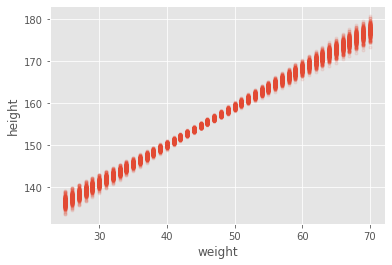

In [30]:
# The link command in the textbook. It's just calculate the average value 
# according to the model on a grid of data.
weight_seq = np.arange(25, 71)
trace_thinned = trace[::10]
mu_pred = np.zeros((len(weight_seq), len(trace_thinned)*trace_thinned.nchains))
for i, w in enumerate(weight_seq):
    mu_pred[i] = trace_thinned['a'] + trace_thinned['b']*(w - d2.weight.mean())
plt.plot(weight_seq, mu_pred, 'C0.', alpha=0.1)
plt.xlabel('weight')
plt.ylabel('height');

The final step is to summerize the distribution for each weight value.

/home/telescreen/Softwares/miniconda3/envs/kaggle/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


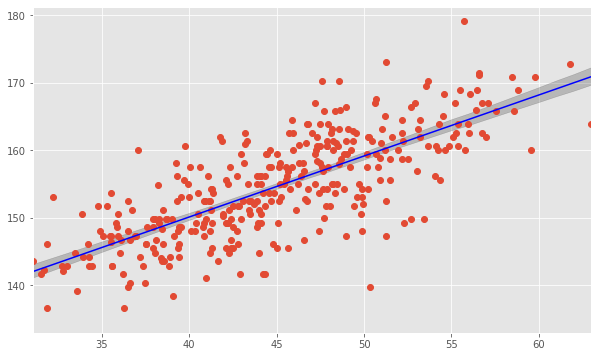

In [31]:
# Summarize the distribution of mu
mu_mean = np.mean(mu_pred, axis=1)
mu_pi = az.hdi(mu_pred.T, hdi_prob=.89)
plt.figure(figsize=(10,6))
plt.plot(d2.weight, d2.height, 'o')
plt.plot(weight_seq, mu_mean, color='b')
plt.fill_between(weight_seq, mu_pi[:,0], mu_pi[:, 1], alpha=0.2, color='k')
plt.xlim(d2.weight.min(), d2.weight.max());

To summerize, here's the recipe for generating predictions and intervals from the posterior of a fit model

1. Generate distributions of posterior values for $\mu$
2. Summary `mean` or `hdi` to find averages and high density interval of $\mu$ for each value of the predictor variable.
3. Use plotting functions to draw the lines and intervals.

Though the confidence interval for the regression line clings tightly to the MAP line, you have to keep in mind that these inferences are always conditional on the model. Even a **bad model** can have very tight confidence intervals. The right way to think of the regression line is: *Conditional on the assumption that height and weight are related by a straight line, then this is the most plausible line, and these are its plausible bounds*

*Prediction intervals*: Let's walk through generating an 89% prediction interval for actual heights, not just the average height, $\mu$.

In our model, we have $h_i \sim Normal(\mu_i, \sigma)$. The Gaussian distribution tells us that height is expected to be distributed around $\mu$. The spread around $\mu$ is governed by $\sigma$.

The plot below shows 89% prediction interval for height, as a function of weight. The solid line is the average line for the mean height at each weight. The two shaded regions show different 89% plausible regions. The wide orange region represents the region within which the model expects to find 89% of actual heights in the population, at each weight.

/home/telescreen/Softwares/miniconda3/envs/kaggle/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/telescreen/Softwares/miniconda3/envs/kaggle/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


AttributeError: module 'arviz' has no attribute 'plot_hpd'

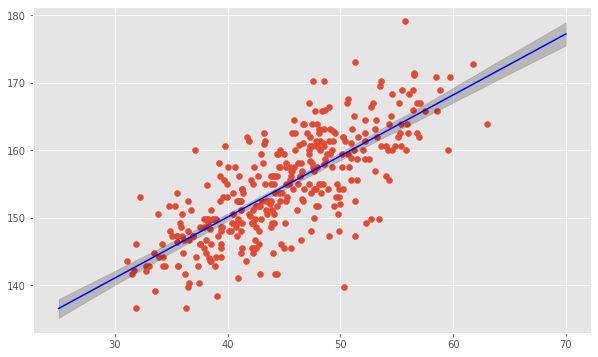

In [32]:
sim_height = pm.sample_posterior_predictive(trace, 1000, model)
height_pi = az.hdi(sim_height['height'], hdi_prob=.89)

plt.figure(figsize=(10,6))
plt.scatter(d2.weight, d2.height)
plt.plot(weight_seq, mu_mean, color='b')
plt.fill_between(weight_seq, mu_pi[:,0], mu_pi[:, 1], alpha=0.2, color='k')
az.plot_hpd(d2.weight, sim_height["height"], ax=plt.gca(), color='orange')
plt.xlim(d2.weight.min(), d2.weight.max());

## Curves from lines

**Polynomial regression**: Polynomial regression uses powers of a variable - squares and cubes - as extra predictors. Let's work through an example using the full !Kung data, not just the adults. The relationship does not look like a straight line. The most common polynomial regression is a parabolic model of the mean

$$ \mu_i = \alpha + \beta_1x_i + \beta_2x_i^2 $$

In [ ]:
plt.scatter(d.weight, d.height)
plt.xlabel('Weight')
plt.ylabel('Height')
plt.title("Height ~ Weight for the whole population");

Fitting these models to data is easy. Interpreting them can be hard.
Fitting model requires we **STANDARDIZE** the predictor variable. When predictor variables have very large values in them, there are sometimes numerical glitches.

To define the parabolic model, just modify the definition of $\mu_i$. Here's the model

$$ h_i \sim Normal(\mu, \sigma) $$
$$ \mu_i = \alpha + \beta_1x_i + \beta_2x_i^2 $$
$$ \alpha \sim Normal(178, 20) $$
$$ \beta_1 \sim LogNormal(0, 1) $$
$$ \beta_2 \sim Normal(0, 1) $$
$$ \sigma \sim Uniform(0, 50) $$

In [ ]:
# Standardize the variable
weight_std = (d.weight - d.weight.mean()) / d.weight.std()
weight_std2 = weight_std**2

with pm.Model() as poly_model:
    alpha = pm.Normal("alpha", mu=178, sigma=20)
    beta1 = pm.Lognormal("beta1", mu=0, sigma=1)
    beta2 = pm.Normal("beta2", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", alpha + beta1*weight_std + beta2*weight_std2)
    
    h = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height)
    trace = pm.sample(1000, tune=1000)

In [ ]:
with poly_model:
    print(az.summary(trace, '~mu', kind='stats', round_to=2))

In [ ]:
print('Standardized Weight range: ({:.2f}, {:.2f})'.format(weight_std.min(), weight_std.max()))
mu_pred = trace['mu']
height_pred = pm.sample_posterior_predictive(trace, 200, poly_model)

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(weight_std, d.height)
az.plot_hpd(weight_std, mu_pred, ax=plt.gca())
az.plot_hpd(weight_std, height_pred['height'], ax=plt.gca());

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w